# Computational Finance Research Notebook

## Load data and Packages

In [1]:
#Load libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from module import * 

In [2]:
#Load data in for in-sample
tickers = ["AMZN", "AAPL", "AMD"]
start = "2010-01-01"
end = "2019-12-31"

df_prices, df_changes = download_stock_price_data(tickers, start, end)

[*********************100%***********************]  3 of 3 completed


In [3]:
#Load data in for out-of-sample
test_start = "2020-01-01"
test_end = "2024-12-31"

test_df_prices, test_df_changes = download_stock_price_data(tickers, test_start, test_end)

[*********************100%***********************]  3 of 3 completed


## Signal 1: Moving Average Crossover with MACD Indicator

#### 1.A) Define signal

In [3]:
def signal01(prices, short_ma, long_ma, short_macd, long_macd, signal_window_macd):

    #MA Signal
    ma_sig, _ = ma_signal(prices, short_ma, long_ma)

    #MACD Signal
    macd_sig, _ = signal_macd(prices, short_macd, long_macd, signal_window_macd)

    #Combine Signals
    combined = combine_two_subsignals(ma_sig, macd_sig)

    #Return combined signal dataframe
    signals = pd.DataFrame(index=prices.index)
    signals['signal'] = combined
    signals['position_change'] = signals['signal'].diff().fillna(0)

    return signals

#### 1.B) Gridsearch best parameters for training set

For the parameter space we choose these parameters because in this literature ...

In [4]:
param_grid = {
    'short_ma': [10, 20, 30, 40, 50],
    'long_ma': [55, 75, 100, 125, 150, 175, 200],
    'short_macd': [12],
    'long_macd': [26],
    'signal_window_macd': [9]
}

all_best_params = {}
for ticker in tickers:
    prices = df_prices[ticker]
    best_params, best_score, results_df = gridsearch_strategy(price=prices, param_grid=param_grid, signal_fn=signal01, metric='sharpe')
    all_best_params[ticker] = best_params
    pd.set_option('display.width', 200)
    pd.set_option('display.max_columns', None)
    print(f"\n=== Results for {ticker} ===")
    print(results_df.head(5))


=== Results for TSLA ===
   short_ma  long_ma  short_macd  long_macd  signal_window_macd  cumret  sharpe  max_dd  volatility
0        10       55          12         26                   9     NaN     NaN     NaN         NaN
1        10       75          12         26                   9     NaN     NaN     NaN         NaN
2        10      100          12         26                   9     NaN     NaN     NaN         NaN
3        10      125          12         26                   9     NaN     NaN     NaN         NaN
4        10      150          12         26                   9     NaN     NaN     NaN         NaN

=== Results for AAPL ===
   short_ma  long_ma  short_macd  long_macd  signal_window_macd     cumret    sharpe    max_dd  volatility
0        50      100          12         26                   9  21.331039  1.014550  0.420161    0.230827
1        50      200          12         26                   9  17.892597  0.971288  0.419505    0.229231
2        30      100       

#### 1.C) Evaluate parameters on test set

We decide to evalute the best parameters on the 2020 to 2024 market regime because...

In [17]:
test_results = {}
for ticker in tickers:
    params = all_best_params[ticker]
    prices = test_df_prices[ticker]
    signal = signal01(prices=prices, **params)
    results = backtest_strategy(prices, signal['signal'])
    test_results[ticker] = {
    'Strategy Cumulative Return': results['Strategy Cumulative Return'],
    'BuyHold Cumulative Return': results['BuyHold Cumulative Return'],
    'Strategy Sharpe': results['Strategy Sharpe'],
    'BuyHold Sharpe': results['BuyHold Sharpe'],
    'Sharpe Delta': results['Sharpe Delta'],
    'Strategy Max Drawdown': results['Strategy Max Drawdown'],
    'BuyHold Max Drawdown': results['BuyHold Max Drawdown'],
    'Strategy Volatility': results['Strategy Volatility'],
    'BuyHold Volatility': results['BuyHold Volatility']}
        
df_test_results = pd.DataFrame.from_dict(test_results)

In [15]:
df_test_results

,Strategy Cumulative Return,BuyHold Cumulative Return,Strategy Sharpe,BuyHold Sharpe,Sharpe Delta,Strategy Max Drawdown,BuyHold Max Drawdown,Strategy Volatility,BuyHold Volatility
TSLA,6.769636,13.552015,1.012187,1.134808,-0.122622,0.669353,0.736322,0.560377,0.671894
AAPL,2.734214,2.464475,1.241876,0.945262,0.296614,0.279492,0.314273,0.235139,0.316891
AMD,1.582447,1.493686,0.655047,0.611055,0.043992,0.506080,0.654499,0.432209,0.524764


#### 1.D) Analysis and Graphs

In [ ]:
plot_buy_and_sell_signals(signal01, test_df_prices, 'AAPL', all_best_params['AAPL'])

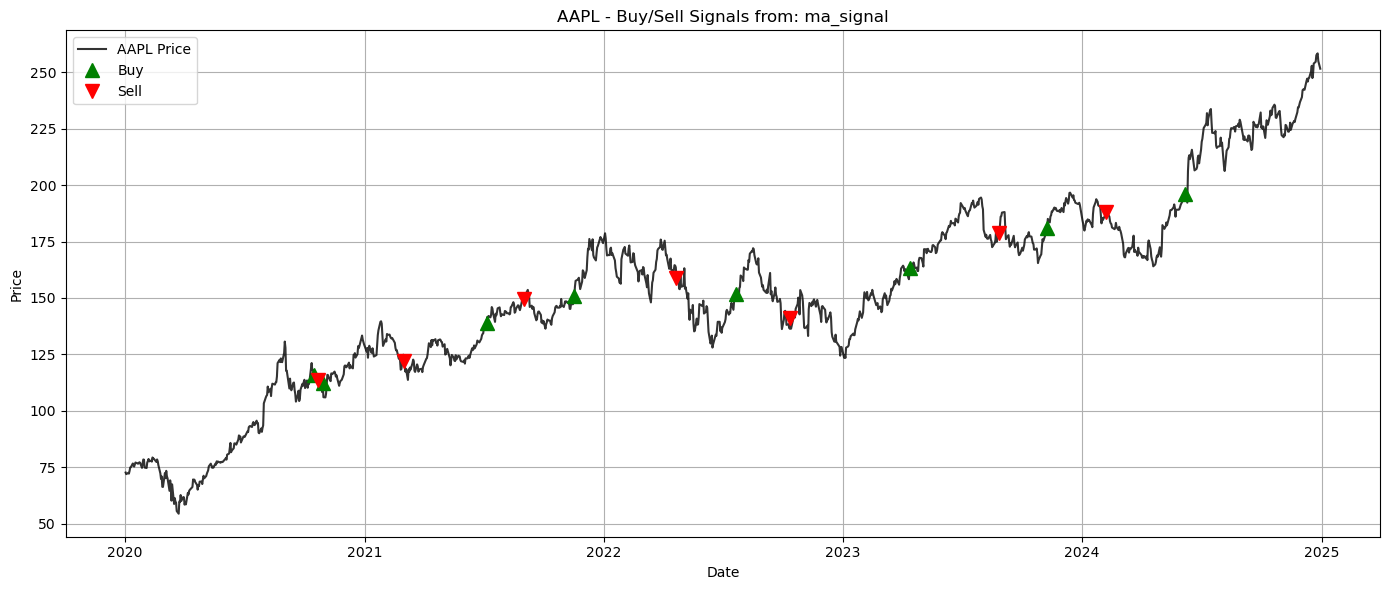

In [47]:
plot_buy_and_sell_signals(ma_signal, test_df_prices, 'AAPL', {'short_window': 50, 'long_window': 200})

## Signal 2: RSI with Bollinger Bands

#### 2.A) Define signal

In [6]:
def signal02(prices, rsi_window_length, lower_rsi_bound, upper_rsi_bound, bollinger_window_length, bollinger_n_stds):

    #RSI Signal
    rsi_sig, _ = signal_rsi(prices, rsi_window_length, lower_rsi_bound, upper_rsi_bound)

    #Bollinger Signal
    bollinger_sig, _ = signal_bollinger(prices, bollinger_window_length, bollinger_n_stds)

    #Combine Signals
    combined = combine_two_subsignals(rsi_sig, bollinger_sig)

    #Return combined signal dataframe
    signals = pd.DataFrame(index=prices.index)
    signals['signal'] = combined
    signals['position_change'] = signals['signal'].diff().fillna(0)

    return signals

#### 2.B) Gridsearch best parameters for training set

In [4]:
param_grid = {
    'rsi_window_length': [10, 14],
    'lower_rsi_bound': [30, 40],
    'upper_rsi_bound': [60, 70],
    'bollinger_window_length': [10, 14],
    'bollinger_n_stds': [1, 1.5, 2]
}

all_best_params = {}
for ticker in tickers:
    prices = df_prices[ticker]
    best_params, best_score, results_df = gridsearch_strategy(price=prices, param_grid=param_grid, signal_fn=signal02, metric='sharpe')
    all_best_params[ticker] = best_params
    pd.set_option('display.width', 200)
    pd.set_option('display.max_columns', None)
    print(f"\n=== Results for {ticker} ===")
    print(results_df.head(3))


=== Results for AMZN ===
   rsi_window_length  lower_rsi_bound  upper_rsi_bound  bollinger_window_length  bollinger_n_stds      cumret  b&h cumret    sharpe  b&h sharpe
0                 14               30               60                       14               1.0  219.292933   12.793054  2.460451    1.003531
1                 10               30               60                       14               1.0  137.978618   12.793054  2.165185    1.003531
2                 14               30               70                       14               1.0  155.176684   12.793054  2.141930    1.003531

=== Results for AAPL ===
   rsi_window_length  lower_rsi_bound  upper_rsi_bound  bollinger_window_length  bollinger_n_stds      cumret  b&h cumret    sharpe  b&h sharpe
0                 14               30               60                       14               1.0  125.580917    9.958799  2.618135    1.061273
1                 10               30               60                       14     

#### 2.C) Evaluate parameters on test set

In [40]:
test_results = {}
for ticker in tickers:
    params = all_best_params[ticker]
    prices = test_df_prices[ticker]
    signal = signal02(prices=prices, **params)
    results = backtest_strategy(prices, signal['signal'])
    test_results[ticker] = {
    'Strategy Cumulative Return': results['Strategy Cumulative Return'],
    'BuyHold Cumulative Return': results['BuyHold Cumulative Return'],
    'Strategy Sharpe': results['Strategy Sharpe'],
    'BuyHold Sharpe': results['BuyHold Sharpe'],
    'Sharpe Delta': results['Sharpe Delta'],
    'Strategy Max Drawdown': results['Strategy Max Drawdown'],
    'BuyHold Max Drawdown': results['BuyHold Max Drawdown'],
    'Strategy Volatility': results['Strategy Volatility'],
    'BuyHold Volatility': results['BuyHold Volatility']}
        
df_test_results = pd.DataFrame.from_dict(test_results)

In [41]:
df_test_results

,TSLA,AAPL,AMD
Strategy Cumulative Return,5.909671,4.788442,58.357152
BuyHold Cumulative Return,13.552015,2.464475,1.493686
Strategy Sharpe,1.005500,1.527637,2.352043
BuyHold Sharpe,1.134808,0.945262,0.611055
Sharpe Delta,-0.129308,0.582374,1.740988
Strategy Max Drawdown,0.651687,0.314273,0.386466
BuyHold Max Drawdown,0.736322,0.314273,0.654499
Strategy Volatility,0.518173,0.251349,0.379192
BuyHold Volatility,0.671894,0.316891,0.524764


#### 2.D) Analysis and interpretation

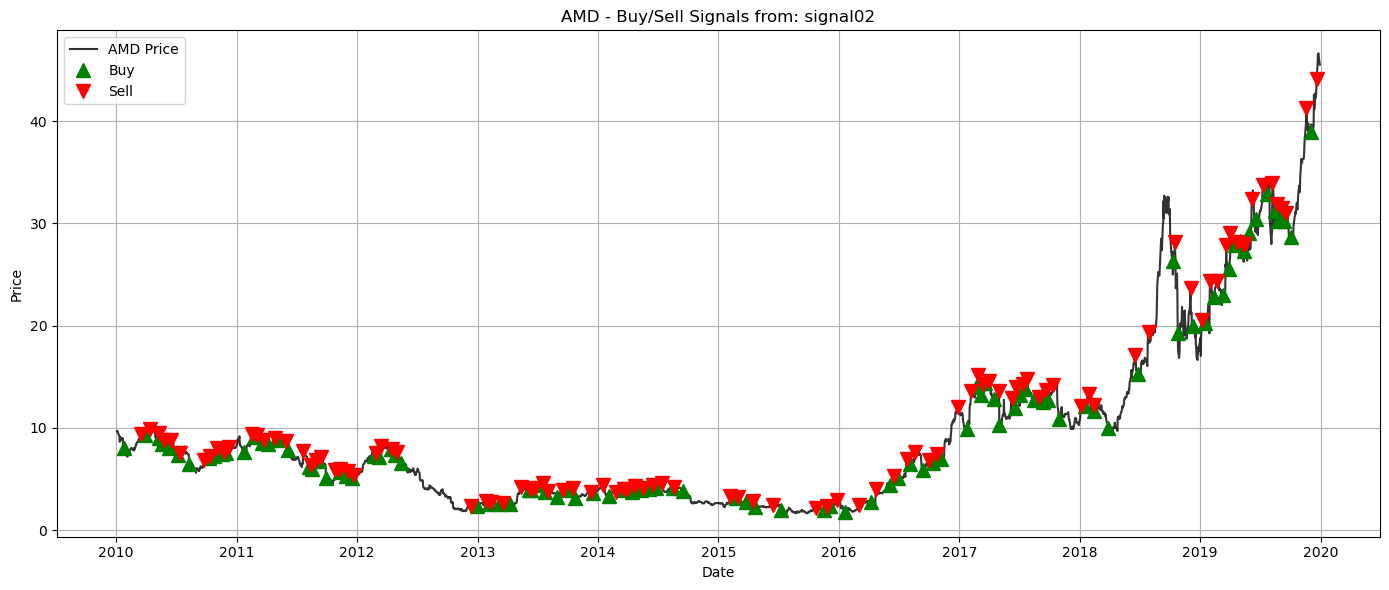

In [30]:
plot_buy_and_sell_signals(signal02, df_prices, 'AMD', all_best_params['AMD'])

## Signal 3: Donchian Channel with ADX

#### 3.A) Define signal

In [ ]:
def signal03(prices, adx_window_length, donchian_window_length):
    
    signals = pd.DataFrame(index=prices.index)
    signals['signal'] = 0.0

    adx = compute_adx(prices, adx_window_length)
    donchian_sig, _ = donchian_signals(prices, donchian_window_length)
    donchian_sig = np.asarray(donchian_sig)

    #Custom tradig logic since adx only detects trends but not in which direction -> combine_two_subsignals() function doesn't work
    position = np.zeros(len(prices), dtype=float)
    holding = 0
    for i in range(len(prices)):
        if np.isnan(adx[i]):
            continue
        if holding == 0 and (donchian_sig[i] == 1 or adx[i] > 25):
            holding = 1
        elif holding == 1 and donchian_sig[i] == 0 and adx[i] > 25:
            holding = 0
        position[i] = holding

    signals['signal'] = position
    signals['position_change'] = signals['signal'].diff().fillna(0)
    signals.iloc[0, signals.columns.get_loc('position_change')] = 0

    return signals

#### 3.B) Gridsearch best Parameters

In [4]:
param_grid = {
    'adx_window_length': [8, 10, 12, 14, 16, 18, 20],
    'donchian_window_length': [8, 10, 12, 14, 16, 18, 20]
}

all_best_params = {}
for ticker in tickers:
    prices = test_df_prices[ticker]
    best_params, best_score, results_df = gridsearch_strategy(price=prices, param_grid=param_grid, signal_fn=signal03, metric='sharpe')
    all_best_params[ticker] = best_params
    pd.set_option('display.width', 200)
    pd.set_option('display.max_columns', None)
    print(f"\n=== Results for {ticker} ===")
    print(results_df.head(3))


=== Results for AMZN ===
   adx_window_length  donchian_window_length  Strategy Cumulative Return  BuyHold Cumulative Return  Strategy Sharpe  BuyHold Sharpe  Sharpe Delta  Strategy Max Drawdown  BuyHold Max Drawdown  \
0                 10                      14                    2.544335                   1.331916         0.963580        0.652038      0.311543               0.453800              0.561453   
1                 10                      20                    2.520529                   1.331916         0.952375        0.652038      0.300337               0.363501              0.561453   
2                 12                      14                    2.559828                   1.331916         0.925922        0.652038      0.273884               0.294851              0.561453   

   Strategy Volatility  BuyHold Volatility  
0             0.314652            0.359757  
1             0.318015            0.359757  
2             0.335755            0.359757  

=== Results 

#### 3.C) Evaluate parameters on test set

In [15]:
test_results = {}
for ticker in tickers:
    params = all_best_params[ticker]
    prices = test_df_prices[ticker]
    signal = signal03(prices=prices, **params)
    results = backtest_strategy(prices, signal['signal'])
    test_results[ticker] = {
    'Strategy Cumulative Return': results['Strategy Cumulative Return'],
    'BuyHold Cumulative Return': results['BuyHold Cumulative Return'],
    'Strategy Sharpe': results['Strategy Sharpe'],
    'BuyHold Sharpe': results['BuyHold Sharpe'],
    'Sharpe Delta': results['Sharpe Delta'],
    'Strategy Max Drawdown': results['Strategy Max Drawdown'],
    'BuyHold Max Drawdown': results['BuyHold Max Drawdown'],
    'Strategy Volatility': results['Strategy Volatility'],
    'BuyHold Volatility': results['BuyHold Volatility']}
        
df_test_results = pd.DataFrame.from_dict(test_results)

In [16]:
df_test_results

,AMZN,AAPL,AMD
Strategy Cumulative Return,2.544335,3.378341,2.055940
BuyHold Cumulative Return,1.331916,2.464474,1.493686
Strategy Sharpe,0.963580,1.250563,0.704563
BuyHold Sharpe,0.652038,0.945262,0.611055
Sharpe Delta,0.311543,0.305301,0.093508
Strategy Max Drawdown,0.453800,0.233727,0.515196
BuyHold Max Drawdown,0.561453,0.314272,0.654499
Strategy Volatility,0.314652,0.265050,0.482935
BuyHold Volatility,0.359757,0.316891,0.524764


#### 3.D) Analyisis and interpretation

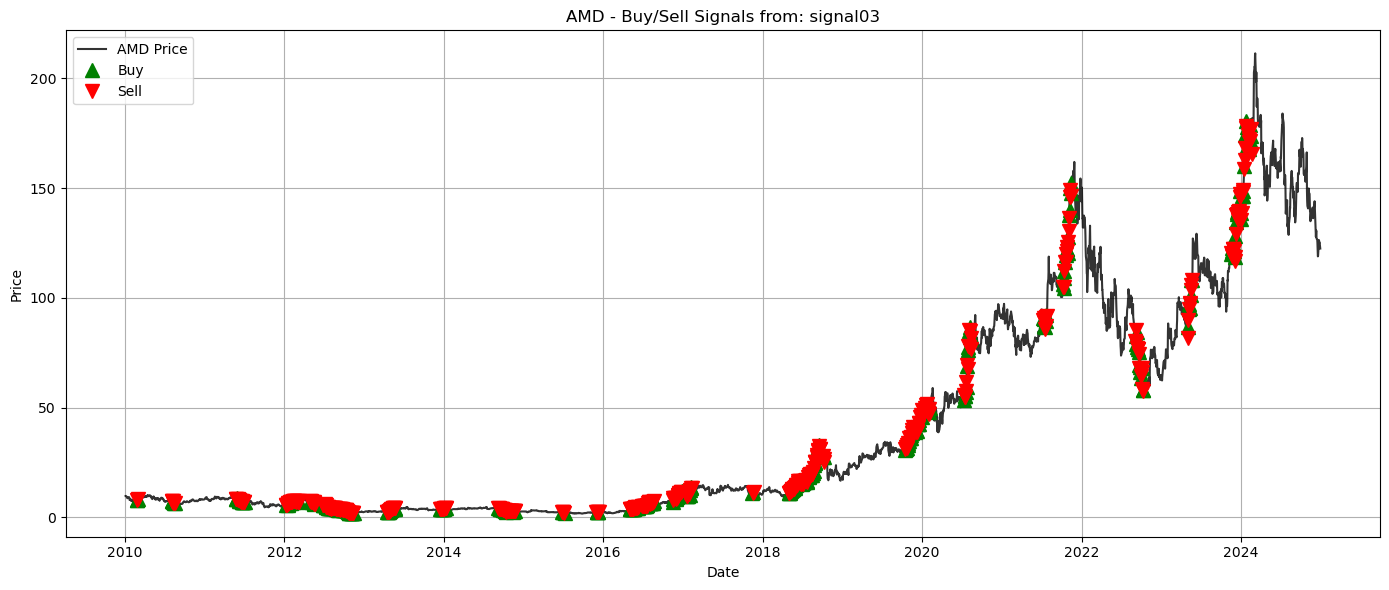

In [18]:
plot_buy_and_sell_signals(signal03, df_prices, 'AMD', all_best_params['AMD'])